# Analyses post scrapping

Objectifs :
- on veut surveiller le nombre de concurrents
- ceux qui arrivent à vendre
- ceux qui changent de stratégie

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import datetime

In [2]:
villes = ['Arcueil', 'Bourg-la-Reine', 'Cachan']
df = pickle.load(open('tous_les_logements.p', 'rb')).drop('texte', axis=1)
df = df[df.ville.isin(villes)].copy()

print(df.shape)
df.tail(2)

(219, 11)


,date_enregistrement,type,ville,description,prix,note,nb_avis,nb_lits,nb_chambres,est_professionnel,est_nouveau
391,2024-01-06,Appartement,Cachan,appartement t1 indépendant. (ga),195,NaN,NaN,2.0,1.0,False,True
392,2024-01-06,Appartement,Cachan,2P a 10 min à pied du RER B,395,NaN,NaN,2.0,1.0,False,False


In [3]:
# Nombre de concurrents
df.groupby(['date_enregistrement', 'ville']).date_enregistrement.count().to_frame().unstack().T

date_enregistrement                 2023-12-20  2023-12-25  2024-01-06
                    ville                                             
date_enregistrement Arcueil                  9          21          17
                    Bourg-la-Reine           8          11           7
                    Cachan                  46          47          53

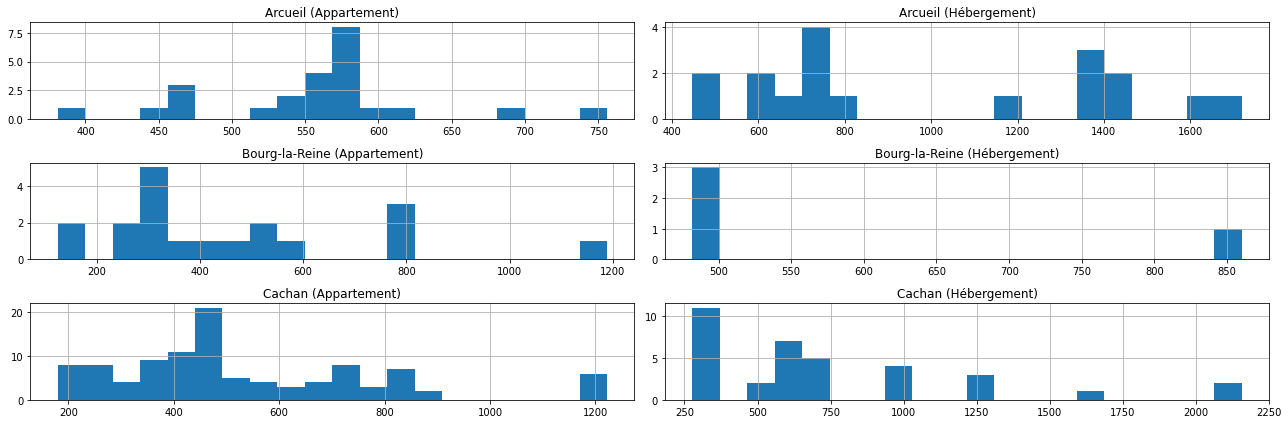

In [4]:
fig = plt.figure(figsize=(18, 6))
num_plot = 1
for ville in villes:
    vue = df[df.ville == ville]
    for type_ in ('Appartement', 'Hébergement'):
        fig.add_subplot(len(villes), 2, num_plot)
        plt.title(f'{ville} ({type_})')
        vue[vue.type == type_].prix.hist(bins=20)
        num_plot += 1
plt.tight_layout()

In [5]:
# Être nouveau augmente les prix
df.groupby('est_nouveau').prix.mean()

est_nouveau
False    605.855491
True     644.760870
Name: prix, dtype: float64

In [6]:
# Être professionnel aussi
df.groupby('est_professionnel').prix.mean()

est_professionnel
False    601.951872
True     684.593750
Name: prix, dtype: float64

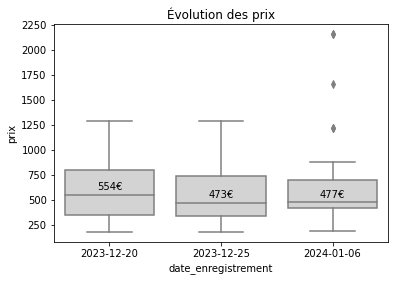

In [15]:
# Comment évoluent les prix ?
import seaborn as sns
vue = df[df.ville == 'Cachan']


sns.boxplot(x=vue.date_enregistrement, y=vue.prix, color='lightgray')
médianes = vue.groupby('date_enregistrement').prix.median()
for i, médiane in enumerate(médianes):
    plt.text(i, médiane + 50, f'{médiane:.0f}€', ha='center')
plt.title('Évolution des prix');

## Suivi des logements dans le temps

In [17]:
df.sample(3)

,date_enregistrement,type,ville,description,prix,note,nb_avis,nb_lits,nb_chambres,est_professionnel,est_nouveau
193,2023-12-25,Appartement,Arcueil,L'Essentiel : Appartement lumineux proche de tout,381,4.86,7.0,NaN,NaN,True,False
159,2023-12-25,Appartement,Cachan,Joli 3 pièces à 10 min de Paris,391,NaN,NaN,NaN,NaN,False,False
137,2023-12-25,Appartement,Bourg-la-Reine,Appt. 30 mins de Paris centre 53m2 balcon calme,295,NaN,NaN,NaN,NaN,False,True


In [18]:
clé = ['type', 'ville', 'description']

In [19]:
vue = df[['date_enregistrement'] + clé + ['prix']].drop_duplicates()
gb = vue.groupby(clé).prix.apply(list).apply(pd.Series)
dates = list(map(lambda d: d.strftime('%Y-%m-%d'), vue.date_enregistrement.unique()))
gb.columns = dates
gb

2023-12-20  \
type            ville          description                                                      
Appartement     Arcueil        Appartement Cocon avec parking privé près de Paris       690.0   
                               Appartement duplex - Arcueil                             565.0   
                               Beau T3 à Arcueil à 3 min RER B « Laplace »              573.0   
                               Home sweet home in Paris                                 579.0   
                               L'Essentiel : Appartement lumineux proche de tout        381.0   
...                                                                                       ...   
Maison de ville Arcueil        Arcueil House (maison de ville)                          611.0   
                Bourg-la-Reine Maison de ville avec jardin                              342.0   
                Cachan         La Maison du Figuier-Direct StadeDeFrance/Airports       728.0   
Villa           Cachan         Jardin fleuri tout près de Paris                         916.0   
                               Maison et jardin boisé A 10 minutes de Paris !           805.0   

                                                                                   2023-12-25  \
type            ville          description                                                      
Appartement     Arcueil        Appartement Cocon avec parking privé près de Paris       558.0   
                               Appartement duplex - Arcueil                             565.0   
                               Beau T3 à Arcueil à 3 min RER B « Laplace »              447.0   
                               Home sweet home in Paris                                 579.0   
                               L'Essentiel : Appartement lumineux proche de tout          NaN   
...                                                                                       ...   
Maison de ville Arcueil        Arcueil House (maison de ville)                            NaN   
                Bourg-la-Reine Maison de ville avec jardin                                NaN   
                Cachan         La Maison du Figuier-Direct StadeDeFrance/Airports         NaN   
Villa           Cachan         Jardin fleuri tout près de Paris                         916.0   
                               Maison et jardin boisé A 10 minutes de Paris !             NaN   

                                                                                   2024-01-06  
type            ville          description                                                     
Appartement     Arcueil        Appartement Cocon avec parking privé près de Paris         NaN  
                               Appartement duplex - Arcueil                             597.0  
                               Beau T3 à Arcueil à 3 min RER B « Laplace »                NaN  
                               Home sweet home in Paris                                   NaN  
                               L'Essentiel : Appartement lumineux proche de tout          NaN  
...                                                                                       ...  
Maison de ville Arcueil        Arcueil House (maison de ville)                            NaN  
                Bourg-la-Reine Maison de ville avec jardin                                NaN  
                Cachan         La Maison du Figuier-Direct StadeDeFrance/Airports         NaN  
Villa           Cachan         Jardin fleuri tout près de Paris                         831.0  
                               Maison et jardin boisé A 10 minutes de Paris !             NaN  

[85 rows x 3 columns]

In [20]:
# Ceux qui changent de stratégie :
gb[gb['2023-12-20'] != gb['2023-12-25']].dropna(how='any')
TODO

,,,2023-12-20,2023-12-25,2024-01-06
type,ville,description,,,
Appartement,Cachan,2P a 10 min à pied du RER B,389.0,380.0,395.0
Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1425.0,1355.0,1387.0


In [ ]:
# Ceux qui ont vendu :
TODO

## Annexes

In [122]:
# Recherche d'une clé primaire : 
variables_dynamiques = ['date_enregistrement', 'est_nouveau', 'note', 'nb_avis']
vue = df.drop(variables_dynamiques, axis=1).drop_duplicates()
vue[vue[clé].duplicated(keep=False)]

# --> les logements qui apparaissent sont ceux qui ont changé de stratégie de prix !
# --> la clé ['ville', 'type', 'description'] identifie donc un logement de façon unique

,type,ville,description,prix,nb_lits,nb_chambres,est_professionnel
41,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1425,NaN,NaN,False
57,Appartement,Cachan,2P a 10 min à pied du RER B,389,NaN,NaN,False
197,Appartement,Cachan,2P a 10 min à pied du RER B,380,NaN,NaN,False
239,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1355,NaN,NaN,False
